In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py
import os

In [2]:
model_folder_name = '13_cccfff'
batch_size = 10000

meta_loading_folder = '/fhgfs/users/jbehnken/01_Data/04_Models/13_cccfff'
meta_loading_path = '/fhgfs/users/jbehnken/01_Data/04_Models/13_cccfff/cccfff.meta'
prediction_save_path = '/fhgfs/users/jbehnken/test_prediction.csv'

In [3]:
def batchYielder():
    with h5py.File('/fhgfs/users/jbehnken/01_Data/02_Crab_Prediction/Crab1314_Images.h5', 'r') as hdf:
        items = list(hdf.items())[0][1].shape[0]
        i = 0

        while (i+1)*batch_size < items/20: # 160 factor to not process everything
            images = np.array(hdf['Image'][ i*batch_size:(i+1)*batch_size ])

            i += 1
            print(i)
            yield images

In [4]:
gpu_config = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.2)
session_conf = tf.ConfigProto(gpu_options=gpu_config, intra_op_parallelism_threads=18, inter_op_parallelism_threads=18)


with tf.Session(config=session_conf) as sess:
    saver = tf.train.import_meta_graph(meta_loading_path)    
    saver.restore(sess, tf.train.latest_checkpoint(meta_loading_folder))
    
    graph = tf.get_default_graph()
    
    #print(sess.graph.get_operations())
    
    try:
        conv2d_1_weights = graph.get_tensor_by_name("conv2d_1/W:0")
        conv2d_1_biases = graph.get_tensor_by_name("conv2d_1/B:0")
        print('Conv2d_1', conv2d_1_weights.shape)
    except: pass
    
    try:
        conv2d_2_weights = graph.get_tensor_by_name("conv2d_2/W:0")
        conv2d_2_biases = graph.get_tensor_by_name("conv2d_2/B:0")
        print('Conv2d_2', conv2d_2_weights.shape)
    except: pass
    
    try:
        conv2d_3_weights = graph.get_tensor_by_name("conv2d_3/W:0")
        conv2d_3_biases = graph.get_tensor_by_name("conv2d_3/B:0")
        print('Conv2d_3', conv2d_3_weights.shape)
    except: pass
    
    try:
        fc_1_weights = graph.get_tensor_by_name("fc_1/W:0")
        fc_1_biases = graph.get_tensor_by_name("fc_1/B:0")
        print('Fc_1', fc_1_weights.shape)
    except: pass
    
    try:
        fc_2_weights = graph.get_tensor_by_name("fc_2/W:0")
        fc_2_biases = graph.get_tensor_by_name("fc_2/B:0")
        print('Fc_2', fc_2_weights.shape)
    except: pass
    
    try:
        fc_3_weights = graph.get_tensor_by_name("fc_3/W:0")
        fc_3_biases = graph.get_tensor_by_name("fc_3/B:0")
        print('Fc_3', fc_3_weights.shape)
    except: pass
    print("Model restored.")
    
    
    #tf_prediction_dataset = tf.constant(images, name='prediction_data')
    tf_prediction_dataset = tf.placeholder(tf.float32, shape=(batch_size, 46, 45, 1), name='training_data')        

    preds_1 = []
    preds_2 = []
    #sess.run(tf.global_variables_initializer())
    
    name = model_folder_name.split('_')[-1]
    for images in batchYielder():
        feed_dict = {tf_prediction_dataset : images}
        
        if name=='cff':
            with tf.name_scope('prediction_cff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_prediction_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')        
                shape = pool_1.get_shape().as_list()
                reshape = tf.reshape(pool_1, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                prediction_cff = tf.nn.softmax(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
            pred = sess.run(prediction_cff, feed_dict=feed_dict)
            
        elif name=='ccff':
            with tf.name_scope('prediction_ccff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_prediction_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_2 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_1, conv2d_2_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_2_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                shape = pool_2.get_shape().as_list()
                reshape = tf.reshape(pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                prediction_ccff = tf.nn.softmax(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
            pred = sess.run(prediction_ccff, feed_dict=feed_dict)
        
        elif name=='cccff':
            with tf.name_scope('prediction_cccff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_prediction_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_2 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_1, conv2d_2_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_2_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_3 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_2, conv2d_3_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_3_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                shape = pool_3.get_shape().as_list()
                reshape = tf.reshape(pool_3, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                prediction_cccff = tf.nn.softmax(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
            pred = sess.run(prediction_cccff, feed_dict=feed_dict)
        
        elif name=='cccfff':
            with tf.name_scope('prediction_cccff'):
                pool_1 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(tf_prediction_dataset, conv2d_1_weights, [1, 1, 1, 1], padding='SAME') + conv2d_1_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_2 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_1, conv2d_2_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_2_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                pool_3 = tf.nn.max_pool(tf.nn.relu(tf.nn.conv2d(pool_2, conv2d_3_weights, [1, 1, 1, 1], padding='SAME')  + conv2d_3_biases), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                shape = pool_3.get_shape().as_list()
                reshape = tf.reshape(pool_3, [shape[0], shape[1] * shape[2] * shape[3]])
                hidden = tf.nn.relu(tf.matmul(reshape, fc_1_weights) + fc_1_biases)
                hidden = tf.nn.relu(tf.matmul(hidden, fc_2_weights) + fc_2_biases)
                prediction_cccfff = tf.nn.softmax(tf.matmul(hidden, fc_3_weights) + fc_3_biases)
            pred = sess.run(prediction_cccfff, feed_dict=feed_dict)
        
        else:
            print('else', name)
            break        

        preds_1.extend(pred[:,0])
        preds_2.extend(pred[:,1])

Conv2d_1 (5, 5, 1, 9)
Conv2d_2 (5, 5, 9, 18)
Conv2d_3 (5, 5, 18, 36)
Fc_1 (1296, 36)
Fc_2 (36, 36)
Fc_3 (36, 2)
Model restored.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102


In [6]:
data = list(zip(preds_1, preds_2))
df = pd.DataFrame(data, columns=['Proton', 'Gamma'])
df.to_csv(prediction_save_path, index=False)

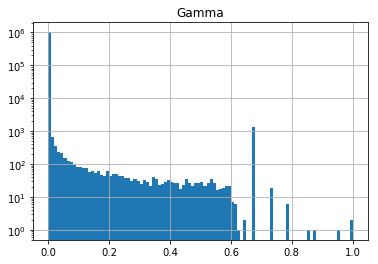

In [7]:
import matplotlib.pyplot as plt
df.hist(['Gamma'], bins=100)
plt.yscale('log')
plt.show()